# TP 1 - NLP
| Nome | Matrícula |
|------|-----------|
| João Vítor Santana Depollo | 2021039751 |

### Setup dependencies & Configuration

In [11]:
%pip install gensim
%pip install numpy
%pip install tabulate
%pip install matplotlib
%pip install scipy


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [12]:
from tabulate import tabulate
import random
import math
from scipy.spatial.distance import cosine
from gensim.models import Word2Vec
from gensim.models.word2vec import Text8Corpus
from matplotlib import pyplot as plt
import time


## Definição de parâmetros e casos de teste

In [13]:
# É possível escolher o modelo entre SKIPGRAM e CBOW
dataset_path = "questions-words.txt"
model = "SKIPGRAM"
corpus = Text8Corpus("text8")

INFINITY = math.inf
# Ajustar valor de acordo com a quantidade de cores com do processador
WORKERS = 4
# Testar frases aleatórias do dataset
run_random_tests = True

def generate_all_parameters(model_type):
    vectors_sizes = [5,10,15,20]
    windows = [ 10,15]
    modes =["SKIPGRAM", "CBOW"]
    # ALPHA = 0.001
    epochs_amount = [2,3]
    
    parameters = []
    for mode in modes:
        for vector_size in vectors_sizes:
            for window in windows:
                for epochs in epochs_amount:
                    parameters.append({
                        # cbow ou skipgram
                        'sg': 1 if mode == "SKIPGRAM" else 0,
                        # Tamanho da janela
                        'window': window,
                        # Tamanho do embedding
                        'vector_size': vector_size,
                        # 'alpha': ALPHA,
                        # Quantidade de iterações de treinamento
                        'epochs': epochs,
                    })
    return parameters

def get_random_test_cases(dataset_path, num_cases=5):
    with open(dataset_path, 'r') as f:
        lines = f.readlines()
    
    valid_lines = [line for line in lines if not line.startswith(':') and len(line.strip().split()) == 4]
    
    random_test_cases = random.sample(valid_lines, min(num_cases, len(valid_lines)))
    
    # Pegar casos de teste aleatórios
    test_cases = [line.strip().split()[:3] for line in random_test_cases]
    
    return test_cases

def extract_word(line):
    if line.startswith(':'):
        return False
    words = line.strip().split()
    if len(words) != 4:
        return False
    return words
    

hyperparameters_set = generate_all_parameters(model)


***

## Treinamento e comparação de modelos

In [14]:

def validate_model(model, dataset_path):
    total = 0
    valid_lines = 0
    with open(dataset_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        words = process_line(line, model)
        if not words:
            continue
        valid_lines += 1
        # Operação de vetores
        # Calc: word 2 - word10 + word3 
        v1 = model.wv[words[1]] - model.wv[words[0]] + model.wv[words[2]]
        v2 = model.wv[words[3]]
        
        distance = cosine(v1, v2)
        total += distance
    return total / valid_lines

def process_line(line,model):
    # Não considerar os grupos de analogias
    words = extract_word(line)
    if not words:
        return False
    if not all(word in model.wv for word in words):
        return False
    return words

best_hyperparameters = None
min_distance = INFINITY
simulations = []
best_setup={
    "model": None,
    "hyperparameters": None,
}
for hyperparameters in hyperparameters_set:
    init = time.time()
    print(f"Running with: {hyperparameters}")
    model = Word2Vec(
    sentences=corpus,
    vector_size=hyperparameters['vector_size'],
    window=hyperparameters['window'],
    sg=hyperparameters['sg'],
    epochs=hyperparameters['epochs'],
    negative=5,
    min_count=5,
    sample=1e-3,
    alpha=0.001,
    workers=WORKERS,
    )
    distance = validate_model  (model, dataset_path)
    end = time.time()
    simulations.append((hyperparameters, distance, end - init))

    if  distance < min_distance :
        min_distance = distance
        best_setup["model"] = model
        best_setup["hyperparameters"] = hyperparameters

    table_data = [
        ["Distance", "Time(s)", "Vector size", "Window", "Mode", "Epochs"],
        [distance, end - init, hyperparameters['vector_size'], hyperparameters['window'], "SKIPGRAM" if hyperparameters['sg'] == 1 else "CBOW", hyperparameters['epochs']]
    ]
    print(tabulate(table_data, headers="firstrow", tablefmt="grid"))

best_params = best_setup["hyperparameters"]
table_data = [
    ["Distance", "Time(s)", "Vector size", "Window", "Mode", "Epochs"],
    [min_distance, best_params['vector_size'], best_params['window'], "SKIPGRAM" if best_params['sg'] == 1 else "CBOW", best_params['epochs']]
]
print(tabulate(table_data, headers="firstrow", tablefmt="grid"))

def comparing_random_test_cases(model, test_cases):
    for analogy in test_cases:
        word_a, word_b, word_c = analogy[:3]
        if all(word in model.wv for word in [word_a, word_b, word_c]):
            result_vector = model.wv[word_b] - model.wv[word_a] + model.wv[word_c]
            closest_word = model.wv.most_similar([result_vector], topn=1)[0][0]
            table_data = [
                ["1", "2", "3", "Closest word"],
                [word_a, word_b, word_c, closest_word]
            ]
            print(tabulate(table_data, headers="firstrow", tablefmt="grid"))
            

if run_random_tests:
    print("Testing random test cases...")
    comparing_random_test_cases(best_setup["model"], get_random_test_cases(dataset_path))


Running with: {'sg': 1, 'window': 10, 'vector_size': 5, 'epochs': 2}
+------------+-----------+---------------+----------+----------+----------+
|   Distance |   Time(s) |   Vector size |   Window | Mode     |   Epochs |
+============+===========+===============+==========+==========+==========+
|      0.232 |   85.6517 |             5 |       10 | SKIPGRAM |        2 |
+------------+-----------+---------------+----------+----------+----------+
Running with: {'sg': 1, 'window': 10, 'vector_size': 5, 'epochs': 3}
+------------+-----------+---------------+----------+----------+----------+
|   Distance |   Time(s) |   Vector size |   Window | Mode     |   Epochs |
+============+===========+===============+==========+==========+==========+
|   0.181872 |   127.018 |             5 |       10 | SKIPGRAM |        3 |
+------------+-----------+---------------+----------+----------+----------+
Running with: {'sg': 1, 'window': 15, 'vector_size': 5, 'epochs': 2}
+------------+-----------+-------

## Resultados

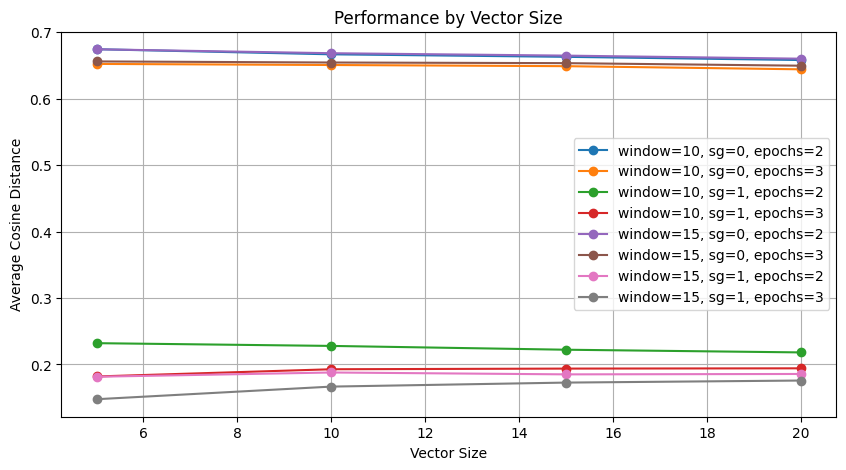

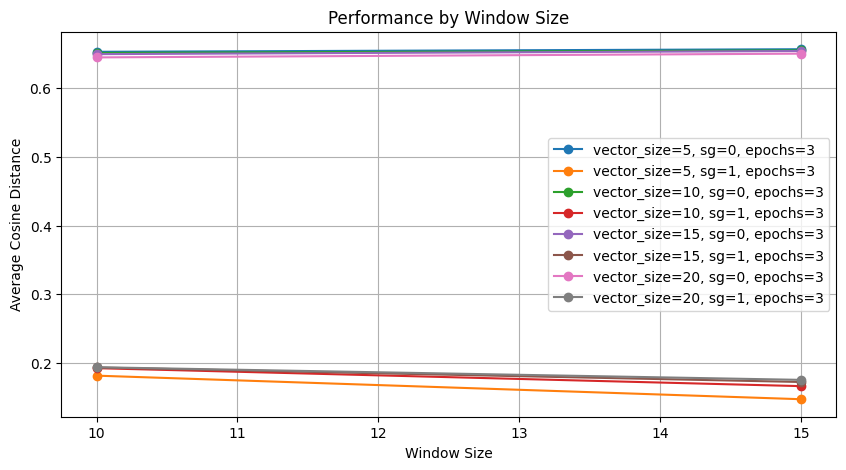

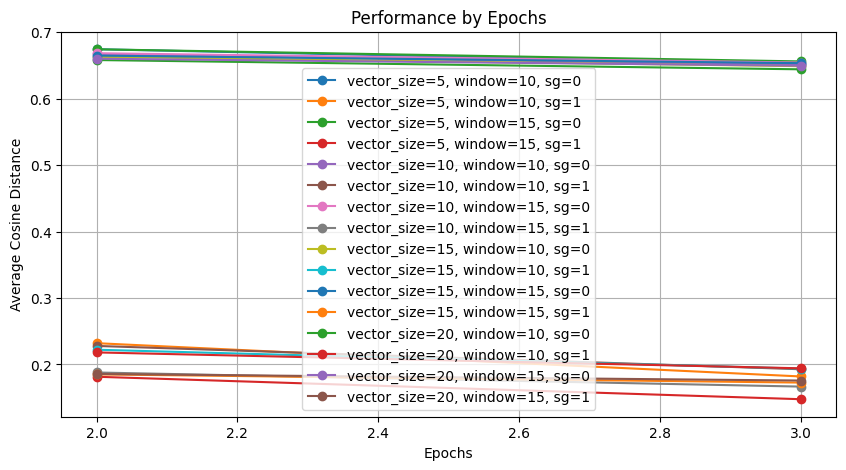

In [15]:
def plot_results(simulations):
    vector_sizes = sorted(set(param['vector_size'] for param,_, _ in simulations))
    windows = sorted(set(param['window'] for param,_, _ in simulations))
    epochs = sorted(set(param['epochs'] for param,_, _ in simulations))

    plt.figure(figsize=(10, 5))
    for window in windows:
        for sg in [0, 1]:
            for epoch in epochs:
                filtered_results = [(param, distance,_) for param, distance,_ in simulations if param['window'] == window and param['sg'] == sg and param['epochs'] == epoch]
                if filtered_results:
                    vector_sizes = [param['vector_size'] for param, _,_ in filtered_results]
                    distances = [distance for _, distance,_ in filtered_results]
                    plt.plot(vector_sizes, distances, marker='o', label=f'window={window}, sg={sg}, epochs={epoch}')
    plt.xlabel('Vector Size')
    plt.ylabel('Average Cosine Distance')
    plt.title('Performance by Vector Size')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    for vector_size in vector_sizes:
        for sg in [0, 1]:
                filtered_results = [(param, distance,_) for param, distance,_ in simulations if param['vector_size'] == vector_size and param['sg'] == sg and param['epochs'] == epoch]
                if filtered_results:
                    windows = [param['window'] for param, _,_ in filtered_results]
                    distances = [distance for _, distance,_ in filtered_results]
                    plt.plot(windows, distances, marker='o', label=f'vector_size={vector_size}, sg={sg}, epochs={epoch}')
    plt.xlabel('Window Size')
    plt.ylabel('Average Cosine Distance')
    plt.title('Performance by Window Size')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot results for epochs
    plt.figure(figsize=(10, 5))
    for vector_size in vector_sizes:
        for window in windows:
            for sg in [0, 1]:
                filtered_results = [(param, distance,_) for param, distance,_ in simulations if param['vector_size'] == vector_size and param['window'] == window and param['sg'] == sg]
                if filtered_results:
                    epochs = [param['epochs'] for param, _,_ in filtered_results]
                    distances = [distance for _, distance,_ in filtered_results]
                    plt.plot(epochs, distances, marker='o', label=f'vector_size={vector_size}, window={window}, sg={sg}')
    plt.xlabel('Epochs')
    plt.ylabel('Average Cosine Distance')
    plt.title('Performance by Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_results(simulations)
